# Library Preparation

In [1]:
!pip install optuna evaluate sentence-transformers -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.9 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from transformers import pipeline, AutoModelForSequenceClassification, AutoTokenizer, DataCollatorWithPadding, get_scheduler 
from datasets import Dataset, Features, Value, ClassLabel
from accelerate import Accelerator, notebook_launcher
from evaluate import load

from sentence_transformers import SentenceTransformer

import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline

from xgboost import XGBClassifier

import optuna
from optuna.samplers import TPESampler

from tqdm import tqdm

import joblib

In [3]:
df = pd.read_csv('/kaggle/input/hasil-scrapping-my-pertamina-04042025/hasil-scrapping.csv')

# Pelabelan

Saya hanya melakukan lowering dan white space removing karena autotokenizer sudah melakukan pra prosess yang lebih sesuai dengan model pretrained. Apabila saya melakukan preprocessing secara mandiri, ditakutkan akan menurunkan performa model karena cara preprocessing yang berbeda.   

**Ini saya note karena sebelumnya submisi saya ditolak karena tidak melakukan preprocessing, padahal dalam kriteria yang dibutuhkan adalah feature extraction, feature extraction saya telah dilakukan dengan metode tf-idf pada cell code dibawah lagi.**

In [4]:
df['content'] = df['content'].str.lower().str.strip()

In [5]:
pretrained= "lxyuan/distilbert-base-multilingual-cased-sentiments-student"

model = AutoModelForSequenceClassification.from_pretrained(pretrained)
tokenizer = AutoTokenizer.from_pretrained(pretrained)

sentiment_analysis = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

results = sentiment_analysis(df['content'].to_list(), batch_size=16)

config.json:   0%|          | 0.00/759 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/541M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/373 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.92M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

Device set to use cuda:0


In [6]:
df['label'] = [result['label'] for result in results]
df['label'].value_counts()

label
negative    23177
positive     6317
neutral       506
Name: count, dtype: int64

In [7]:
le = LabelEncoder()

X = df['content']
y = le.fit_transform(df['label'])

# Skema 1:

feature_extractor = "tfidfvectorizer"   
train_test_split = 0.8 train/0.2 test/random_state=42/stratify y  
model = XGBoost Classifier  
hyperparameter tuning = bayesian search using optuna 100 iterations  

## Proses Training

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2, stratify=y)
X_train = X_train.str.lower()
X_test = X_test.str.lower()

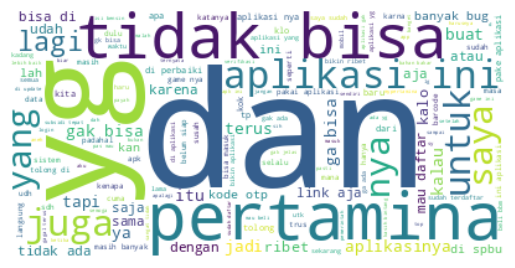

In [9]:
from wordcloud import WordCloud

text = " ".join(text for text in X_train)

# Generate a word cloud image
wordcloud = WordCloud(background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [10]:
tf_idf_best_params = dict(
    ngram_range= (1, 2),
    use_idf= False,
    max_features= None,
    sublinear_tf= False
)

xgb_best_params = dict(
    learning_rate= 0.08659961156817399,
    max_depth= 8,
    n_estimators= 600,
    subsample= 0.763150470877663,
    colsample_bytree= 0.5939964783208691,
    gamma= 2.4559180064649005e-09
)

vectorizer = TfidfVectorizer(**tf_idf_best_params)

classifier = XGBClassifier(
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss',
    **xgb_best_params
)

pipeline = Pipeline([
    ('Feature Extractor Tfidf', vectorizer),
    ('Classifier', classifier)
])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('Feature Extractor Tfidf',
                 TfidfVectorizer(ngram_range=(1, 2), use_idf=False)),
                ('Classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.5939964783208691, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='logloss',
                               feature_types=None, g...
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.08659961156817399, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=8,
                               max_leaves=None, min_child_weight=None,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=600,
                               n_jobs=None, num_parallel_tree=None,
                               objective='multi:softprob', ...))])

In [11]:
joblib.dump(le, 'label_encoder.joblib')
joblib.dump(pipeline, 'xgb_sentiment_analysis_pipeline.joblib')

['xgb_sentiment_analysis_pipeline.joblib']

uncomment kode dibawah untuk melakukan hyperparameter tuning, seed sudah diatur sehingga hasil tetap konsisten, optimal pada iterasi ke 48.

In [12]:
# def objective(trial):
#     # Parameter space untuk TfidfVectorizer
#     ngram_range = trial.suggest_categorical('ngram_range', [(1,1), (1,2)])
#     max_features = trial.suggest_categorical('max_features', [None, 1000, 2000, 3000, 4000, 5000])
#     use_idf = trial.suggest_categorical('use_idf', [True, False])
#     sublinear_tf = trial.suggest_categorical('sublinear_tf', [True, False])
    
#     # Parameter space untuk XGBClassifier
#     learning_rate = trial.suggest_float('learning_rate', 1e-3, 0.3, log=True)
#     max_depth = trial.suggest_int('max_depth', 3, 10)
#     n_estimators = trial.suggest_int('n_estimators', 100, 1000, step=100)
#     subsample = trial.suggest_float('subsample', 0.5, 1.0)
#     colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0)
#     gamma = trial.suggest_float('gamma', 1e-9, 1.0, log=True)
    
#     # Membuat pipeline dengan parameter yang diuji
#     vectorizer = TfidfVectorizer(
#         ngram_range=ngram_range,
#         max_features=max_features,
#         use_idf=use_idf,
#         sublinear_tf=sublinear_tf
#     )
    
#     classifier = XGBClassifier(
#         learning_rate=learning_rate,
#         max_depth=max_depth,
#         n_estimators=n_estimators,
#         subsample=subsample,
#         colsample_bytree=colsample_bytree,
#         gamma=gamma,
#         random_state=42,
#         use_label_encoder=False,
#         eval_metric='logloss'
#     )
    
#     pipeline = Pipeline([
#         ('Feature Extractor Tfidf', vectorizer),
#         ('Classifier', classifier)
#     ])

#     pipeline.fit(X_train, y_train)
    
#     return pipeline.score(X_test, y_test)

# # Membuat study Optuna
# study = optuna.create_study(
#     direction='maximize',
#     sampler=TPESampler(seed=42))
# study.optimize(objective, n_trials=100)

# # Menampilkan hasil terbaik
# print("Best trial:")
# trial = study.best_trial

# print(f"  Value (Accuracy): {trial.value:.5f}")
# print("  Params: ")
# for key, value in trial.params.items():
#     print(f"    {key}: {value}")

## Proses Evaluasi

In [13]:
print(classification_report(y_train, pipeline.predict(X_train)))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99     18541
           1       1.00      0.95      0.97       405
           2       0.99      0.91      0.94      5054

    accuracy                           0.98     24000
   macro avg       0.99      0.95      0.97     24000
weighted avg       0.98      0.98      0.98     24000



In [14]:
print(classification_report(y_test, pipeline.predict(X_test)))

              precision    recall  f1-score   support

           0       0.89      0.96      0.93      4636
           1       0.48      0.12      0.19       101
           2       0.82      0.64      0.72      1263

    accuracy                           0.88      6000
   macro avg       0.73      0.57      0.61      6000
weighted avg       0.87      0.88      0.87      6000



# Skema 2

model: finetuning huggingface "lxyuan/distilbert-base-multilingual-cased-sentiments-student"  
feature_extractor = "default tokenizer"   
train_test_split = 0.8 train/0.2 test/random_state=42/stratify y 

In [15]:
features = Features({
    'content': Value('string'),
    'label': ClassLabel(num_classes=3, names=df['label'].unique().tolist()),
})

data = Dataset.from_pandas(df, features=features)
data = data.train_test_split(test_size=0.2, seed=42, stratify_by_column='label')

In [16]:
def evaluate_with_huggingface_metrics(model, dataloader, accelerator):
    model.eval()
    metric = load("accuracy")  # Muat metrik akurasi
    
    for batch in dataloader:
        with torch.no_grad():
            outputs = model(**batch)
        
        # Ambil prediksi dan label
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=1)
        labels = batch["labels"]
        
        # Kumpulkan prediksi dan label dari semua proses (jika distributed)
        predictions, labels = accelerator.gather_for_metrics(
            (predictions, labels))
        
        # Update metrik
        metric.add_batch(predictions=predictions, references=labels)
    
    # Hitung akurasi akhir
    accuracy = metric.compute()["accuracy"]
    return accuracy

In [17]:
def training_function():
    checkpoint = 'mdhugol/indonesia-bert-sentiment-classification'
    tokenizer = AutoTokenizer.from_pretrained(checkpoint)
    
    # Tokenisasi dataset
    def tokenize_function(example):
        return tokenizer(example['content'], truncation=True, padding="max_length")
    
    tokenized_datasets = data.map(tokenize_function, batched=True)
    tokenized_datasets = tokenized_datasets.remove_columns(['content'])
    tokenized_datasets = tokenized_datasets.rename_column('label', 'labels')
    tokenized_datasets.set_format('torch')
    
    # Siapkan DataLoader
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
    train_dataloader = DataLoader(
        tokenized_datasets["train"], shuffle=True, batch_size=8, collate_fn=data_collator
    )
    test_dataloader = DataLoader(
        tokenized_datasets["test"], batch_size=8, collate_fn=data_collator
    )
    
    # Inisialisasi model, optimizer, dan accelerator
    accelerator = Accelerator()
    model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=3)
    optimizer = AdamW(model.parameters(), lr=3e-5)
    
    # Siapkan komponen untuk distributed training
    train_dataloader, test_dataloader, model, optimizer = accelerator.prepare(
        train_dataloader, test_dataloader, model, optimizer
    )
    
    num_epochs = 3
    for epoch in range(num_epochs):
        # Training Phase
        model.train()
        for batch in train_dataloader:
            outputs = model(**batch)
            loss = outputs.loss
            accelerator.backward(loss)
            optimizer.step()
            optimizer.zero_grad()
        
        # Evaluasi dengan Hugging Face Metrics
        train_accuracy = evaluate_with_huggingface_metrics(model, train_dataloader, accelerator)
        test_accuracy = evaluate_with_huggingface_metrics(model, test_dataloader, accelerator)
        
        accelerator.print(f"\nEpoch {epoch + 1}")
        accelerator.print(f"Train Accuracy: {train_accuracy:.4f}")
        accelerator.print(f"Test Accuracy: {test_accuracy:.4f}")

# Jalankan training loop dengan notebook_launcher
notebook_launcher(training_function, num_processes=1)

Launching training on one GPU.


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Map:   0%|          | 0/24000 [00:00<?, ? examples/s]

Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/6000 [00:00<?, ? examples/s]

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]


Epoch 1
Train Accuracy: 0.9207
Test Accuracy: 0.8935

Epoch 2
Train Accuracy: 0.9409
Test Accuracy: 0.8845

Epoch 3
Train Accuracy: 0.9606
Test Accuracy: 0.8972


# Skema 3

In [18]:
X = df['content']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3, stratify=y)
model_embedder = SentenceTransformer('intfloat/multilingual-e5-large')
X_train_embeddings = model_embedder.encode(X_train.to_list())
X_test_embeddings = model_embedder.encode(X_test.to_list())

modules.json:   0%|          | 0.00/387 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/160k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/690 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/418 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/201 [00:00<?, ?B/s]

Batches:   0%|          | 0/657 [00:00<?, ?it/s]

Batches:   0%|          | 0/282 [00:00<?, ?it/s]